In [1]:
import numpy as np

In [2]:
import pertpy as pt

/home/kvalem/.conda/envs/pertpy-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/kvalem/.conda/envs/pertpy-env/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/kvalem/.conda/envs/pertpy-env/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/kvalem/.conda/envs/pertpy-env/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/home/kvalem/.conda/envs/pertpy-env/lib/python3.10/site-p

In [3]:
import scanpy as sc

In [4]:
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import mudata as mu

In [5]:
import sccoda.util.cell_composition_data as scc_dat
import sccoda.util.comp_ana as scc_ana
import sccoda.util.data_visualization as scc_viz

In [6]:
import altair as alt

In [7]:
import pandas as pd

In [8]:
import tensorflow as tf

In [9]:
tf.random.set_seed(0)

In [10]:
sc.settings.set_figure_params(
    dpi=200,
    facecolor="white",
    frameon=False,
)

In [11]:
path = "/data/projects/2023/LCBiome/nsclc_gender_atlas_tmp/out/011_analysis_paired_remove_xy/pseudobulk/"
resDir = "/data/projects/2023/LCBiome/nsclc_gender_atlas_tmp/out/011_analysis_paired_remove_xy/figures/"
input_path = f"{path}/paired_adata_clean.h5ad"

In [12]:
adata = sc.read_h5ad("/data/projects/2023/LCBiome/nsclc_gender_atlas_tmp/out/012_LUAD/old/pseudobulk/paired_adata_clean_luad_all_cell_type.h5ad")

In [13]:
# Define the cell types to keep
selected_cell_types = {
    'macrophage',
    'CD4+ T cell',
    'CD8+ T cell',
    'B cell',
    'malignant cell',
    'regulatory T cell',
    'epithelial cell',
    'neutrophil',
    'dendritic cell',
    'plasma cell',
    'endothelial cell',
    'fibroblast'
}

# Mapping for synonymous cell types in adata
cell_type_mapping = {
    'fibroblast of lung': 'fibroblast',
    'vein endothelial cell': 'endothelial cell',
    'capillary endothelial cell': 'endothelial cell',
    'pulmonary artery endothelial cell': 'endothelial cell',
    'endothelial cell of lymphatic vessel': 'endothelial cell',
    'conventional dendritic cell': 'dendritic cell',
    'CD1c-positive myeloid dendritic cell': 'dendritic cell',
    'plasmacytoid dendritic cell': 'dendritic cell',
    'bronchus fibroblast of lung': 'fibroblast'
}

# Standardize cell types based on mapping
adata.obs['standardized_cell_type'] = adata.obs['cell_type'].replace(cell_type_mapping)

# Filter adata to keep only selected cell types
adata = adata[adata.obs['standardized_cell_type'].isin(selected_cell_types)].copy()

# Verify result
print(adata.obs['standardized_cell_type'].value_counts())


standardized_cell_type
macrophage           104271
CD4+ T cell           94503
CD8+ T cell           72603
epithelial cell       21039
malignant cell        16939
B cell                16853
regulatory T cell     16785
dendritic cell        16702
endothelial cell      16150
plasma cell           15096
neutrophil             6146
fibroblast             4674
Name: count, dtype: int64


## There are malignant cells in normal_adjacent samples
Comming from 59 different patients and 14 datasets
I cannot give an explanation for this so i remove this "mislalbeled" cells 

In [14]:
grouped = adata.obs.groupby(['cell_type', 'origin']).size().reset_index(name='cell_count')

In [15]:
grouped

,cell_type,origin,cell_count
0,epithelial cell,normal_adjacent,4957
1,epithelial cell,tumor_primary,16082
2,macrophage,normal_adjacent,65453
3,macrophage,tumor_primary,38818
4,B cell,normal_adjacent,2888
5,B cell,tumor_primary,13965
6,dendritic cell,normal_adjacent,348
7,dendritic cell,tumor_primary,579
8,CD4+ T cell,normal_adjacent,45654
9,CD4+ T cell,tumor_primary,48849


In [16]:
# Create a Boolean mask for the cells that you want to keep
mask = ~((adata.obs['origin'] == 'normal_adjacent') & (adata.obs['cell_type'] == 'malignant cell'))

# Subset the adata object using the mask to exclude the specific cells
adata = adata[mask].copy()

# Now `adata_filtered` contains all cells except those with origin == 'normal_adjacent' and cell_type == 'malignant cell'


In [17]:
grouped = adata.obs.groupby(['cell_type', 'origin']).size().reset_index(name='cell_count')
grouped

,cell_type,origin,cell_count
0,epithelial cell,normal_adjacent,4957
1,epithelial cell,tumor_primary,16082
2,macrophage,normal_adjacent,65453
3,macrophage,tumor_primary,38818
4,B cell,normal_adjacent,2888
5,B cell,tumor_primary,13965
6,dendritic cell,normal_adjacent,348
7,dendritic cell,tumor_primary,579
8,CD4+ T cell,normal_adjacent,45654
9,CD4+ T cell,tumor_primary,48849


In [18]:
adata_normal = adata[adata.obs["origin"]=="normal_adjacent"]
#adata_normal = adata_normal[~adata_normal.obs["cell_type"].isin(["malignant cell"])]

In [19]:
set(adata_normal.obs.cell_type)

{'B cell',
 'CD1c-positive myeloid dendritic cell',
 'CD4+ T cell',
 'CD8+ T cell',
 'bronchus fibroblast of lung',
 'capillary endothelial cell',
 'conventional dendritic cell',
 'dendritic cell',
 'endothelial cell of lymphatic vessel',
 'epithelial cell',
 'fibroblast of lung',
 'macrophage',
 'neutrophil',
 'plasma cell',
 'plasmacytoid dendritic cell',
 'pulmonary artery endothelial cell',
 'regulatory T cell',
 'vein endothelial cell'}

In [20]:
adata_tumor = adata[adata.obs["origin"]=="tumor_primary"]

In [21]:
set(adata_normal.obs.cell_type)

{'B cell',
 'CD1c-positive myeloid dendritic cell',
 'CD4+ T cell',
 'CD8+ T cell',
 'bronchus fibroblast of lung',
 'capillary endothelial cell',
 'conventional dendritic cell',
 'dendritic cell',
 'endothelial cell of lymphatic vessel',
 'epithelial cell',
 'fibroblast of lung',
 'macrophage',
 'neutrophil',
 'plasma cell',
 'plasmacytoid dendritic cell',
 'pulmonary artery endothelial cell',
 'regulatory T cell',
 'vein endothelial cell'}

In [22]:
adata_normal = adata[adata.obs["origin"]=="normal_adjacent"]
#adata_normal = adata_normal[~adata_normal.obs["cell_type"].isin(["malignant cell"])]

In [23]:
adata_tumor = adata[adata.obs["origin"]=="tumor_primary"]

In [24]:
adata

AnnData object with n_obs × n_vars = 401187 × 17811
    obs: 'sample', 'uicc_stage', 'ever_smoker', 'age', 'donor_id', 'origin', 'dataset', 'ann_fine', 'cell_type_predicted', 'doublet_status', 'leiden', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'ann_coarse', 'cell_type_tumor', 'tumor_stage', 'EGFR_mutation', 'TP53_mutation', 'ALK_mutation', 'BRAF_mutation', 'ERBB2_mutation', 'KRAS_mutation', 'ROS_mutation', 'origin_fine', 'study', 'platform', 'cell_type_major', 'cell_type_neutro', 'cell_type_neutro_coarse', 'suspension_type', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'standardized_cell_type'
    var: 'is_highly_variable', 'm

In [25]:
adata_luad = adata[adata.obs["disease"]=="lung adenocarcinoma"]

In [26]:
adata_luad

View of AnnData object with n_obs × n_vars = 401187 × 17811
    obs: 'sample', 'uicc_stage', 'ever_smoker', 'age', 'donor_id', 'origin', 'dataset', 'ann_fine', 'cell_type_predicted', 'doublet_status', 'leiden', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'ann_coarse', 'cell_type_tumor', 'tumor_stage', 'EGFR_mutation', 'TP53_mutation', 'ALK_mutation', 'BRAF_mutation', 'ERBB2_mutation', 'KRAS_mutation', 'ROS_mutation', 'origin_fine', 'study', 'platform', 'cell_type_major', 'cell_type_neutro', 'cell_type_neutro_coarse', 'suspension_type', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'standardized_cell_type'
    var: 'is_highly_varia

In [27]:
adata_luad_tumor = adata_luad[adata_luad.obs["origin"]=="tumor_primary"]

# Male & Female Tumor vs Normal 

In [ ]:
# Convert data to mudata object
sccoda_model = pt.tl.Sccoda()
sccoda_data = sccoda_model.load(
    adata_luad,
    type="cell_level",
    generate_sample_level=True,
    cell_type_identifier="cell_type",
    sample_identifier="sample",
    covariate_obs=["age","sex","dataset","origin","disease"],
)

# Select control and salmonella data as one modality
sccoda_data.mod["coda_sex"] = sccoda_data["coda"][
    sccoda_data["coda"].obs["sex"].isin(["male", "female"])
].copy()
print(sccoda_data)



In [ ]:
sccoda_model.plot_boxplots(sccoda_data, modality_key="coda_sex", feature_name="origin", add_dots=False)
plt.show()

In [ ]:
fig = sccoda_model.plot_stacked_barplot(
    sccoda_data,
    modality_key="coda_sex",
    feature_name="sex"

)

In [ ]:
sccoda_model.plot_rel_abundance_dispersion_plot(sccoda_data, modality_key="coda_sex", abundant_threshold=0.9)

In [ ]:
sccoda_data = sccoda_model.prepare(
    sccoda_data,
    modality_key="coda_sex",
    formula = "sex + origin",
    reference_cell_type="automatic",
    automatic_reference_absence_threshold=1
)
sccoda_data["coda_sex"]

In [ ]:
sccoda_data

In [ ]:
# Run MCMC
sccoda_model.run_nuts(sccoda_data, modality_key="coda_sex")
sccoda_data["coda_sex"]

In [ ]:
sccoda_model.set_fdr(sccoda_data, modality_key="coda_sex", est_fdr=0.1)


In [ ]:
sccoda_model.summary(sccoda_data, modality_key="coda_sex")

In [ ]:
sccoda_model.summary(sccoda_data, modality_key="coda_sex", extended=True)

In [ ]:
sccoda_model.credible_effects(sccoda_data, modality_key="coda_sex")

In [ ]:
sccoda_model.plot_effects_barplot(sccoda_data, modality_key="coda_sex", parameter="log2-fold change",figsize=(10,5))

In [ ]:
sccoda_model.get_effect_df(sccoda_data, modality_key="coda_sex")

In [ ]:
alt.Chart(sccoda_model.get_effect_df(sccoda_data, modality_key="coda_sex").loc["sexT.male"]
    #.loc[credible_effects_condition]
    .reset_index(),
    title="Male vs Female",
).mark_bar().encode(
    x="log2-fold change",
    y=alt.X("Cell Type", sort="y"),
    color=alt.Color("Cell Type"),
)

In [ ]:
alt.Chart(sccoda_model.get_effect_df(sccoda_data, modality_key="coda_sex").loc["originT.tumor_primary"]
    #.loc[credible_effects_condition]
    .reset_index(),
    title="Tumor vs Normal",
).mark_bar().encode(
    x="log2-fold change",
    y=alt.X("Cell Type", sort="y"),
    color=alt.Color("Cell Type"),
)

In [ ]:
sccoda_model.plot_stacked_barplot(sccoda_data, modality_key="coda_sex", feature_name="sex")
plt.show()

In [ ]:
sccoda_model.plot_boxplots(sccoda_data, modality_key="coda_sex", feature_name="origin", add_dots=False)
plt.show()

In [ ]:
adata_male = adata[adata.obs["sex"]=="male"]

In [ ]:
# Convert data to mudata object
sccoda_model = pt.tl.Sccoda()
sccoda_data = sccoda_model.load(
    adata_male,
    type="cell_level",
    generate_sample_level=True,
    cell_type_identifier="cell_type",
    sample_identifier="sample",
    covariate_obs=["age","sex","dataset","origin"],
)

# Select control and salmonella data as one modality
sccoda_data.mod["coda_male_origin"] = sccoda_data["coda"][
    sccoda_data["coda"].obs["origin"].isin(["tumor_primary", "normal_adjacent"])
].copy()
print(sccoda_data)



In [ ]:
sccoda_model.plot_boxplots(sccoda_data, modality_key="coda_male_origin", feature_name="origin", add_dots=False)
plt.show()

In [ ]:
fig = sccoda_model.plot_stacked_barplot(
    sccoda_data,
    modality_key="coda_male_origin",
    feature_name="origin"

)

In [ ]:
sccoda_model.plot_rel_abundance_dispersion_plot(sccoda_data, modality_key="coda_male_origin", abundant_threshold=0.9)

In [ ]:
sccoda_data = sccoda_model.prepare(
    sccoda_data,
    modality_key="coda_male_origin",
    formula = "origin",
    reference_cell_type="automatic",
    automatic_reference_absence_threshold=1
)
sccoda_data["coda_male_origin"]

In [ ]:
sccoda_data

In [ ]:
# Run MCMC
sccoda_model.run_nuts(sccoda_data, modality_key="coda_male_origin")
sccoda_data["coda_male_origin"]

In [ ]:
sccoda_model.set_fdr(sccoda_data, modality_key="coda_male_origin", est_fdr=0.1)


In [ ]:
sccoda_model.summary(sccoda_data, modality_key="coda_male_origin")

In [ ]:
sccoda_model.summary(sccoda_data, modality_key="coda_male_origin", extended=True)

In [ ]:
sccoda_model.credible_effects(sccoda_data, modality_key="coda_male_origin")

In [ ]:
sccoda_model.plot_effects_barplot(sccoda_data, modality_key="coda_male_origin", parameter="log2-fold change",figsize=(10,5))

In [ ]:
sccoda_model.get_effect_df(sccoda_data, modality_key="coda_male_origin")

In [ ]:
alt.Chart(sccoda_model.get_effect_df(sccoda_data, modality_key="coda_male_origin").loc["originT.tumor_primary"]
    #.loc[credible_effects_condition]
    .reset_index(),
    title="Only Male Tumor vs Normal",
).mark_bar().encode(
    x="log2-fold change",
    y=alt.X("Cell Type", sort="y"),
    color=alt.Color("Cell Type"),
)

In [ ]:
sccoda_model.plot_stacked_barplot(sccoda_data, modality_key="coda_male_origin", feature_name="origin")
plt.show()

# Only Tumor Male vs Female 

In [ ]:
adata_luad_tumor = adata_luad[adata_luad.obs["origin"]=="tumor_primary"]

In [ ]:
# Convert data to mudata object
sccoda_model = pt.tl.Sccoda()
sccoda_data = sccoda_model.load(
    adata_luad_tumor,
    type="cell_level",
    generate_sample_level=True,
    cell_type_identifier="cell_type",
    sample_identifier="sample",
    covariate_obs=["age","sex","dataset","origin","disease"],
)

# Select control and salmonella data as one modality
sccoda_data.mod["coda_tumor_mvsf"] = sccoda_data["coda"][
    sccoda_data["coda"].obs["sex"].isin(["male", "female"])
].copy()
print(sccoda_data)



In [ ]:
sccoda_model.plot_boxplots(sccoda_data, modality_key="coda_tumor_mvsf", feature_name="sex", add_dots=False)
plt.show()

In [ ]:
fig = sccoda_model.plot_stacked_barplot(
    sccoda_data,
    modality_key="coda_tumor_mvsf",
    feature_name="sex"

)

In [ ]:
sccoda_model.plot_rel_abundance_dispersion_plot(sccoda_data, modality_key="coda_tumor_mvsf", abundant_threshold=0.9)

In [ ]:
sccoda_data = sccoda_model.prepare(
    sccoda_data,
    modality_key="coda_tumor_mvsf",
   formula = "sex + origin",
    reference_cell_type="macrophage",
    automatic_reference_absence_threshold=1
)
sccoda_data["coda_tumor_mvsf"]

In [ ]:
sccoda_data

In [ ]:
# Run MCMC
sccoda_model.run_nuts(sccoda_data, modality_key="coda_tumor_mvsf")
sccoda_data["coda_tumor_mvsf"]

In [ ]:
sccoda_model.set_fdr(sccoda_data, modality_key="coda_tumor_mvsf", est_fdr=0.2)

In [ ]:
sccoda_model.summary(sccoda_data, modality_key="coda_tumor_mvsf")

In [ ]:
sccoda_model.summary(sccoda_data, modality_key="coda_tumor_mvsf", extended=True)

In [ ]:
sccoda_model.credible_effects(sccoda_data, modality_key="coda_tumor_mvsf")

In [ ]:
sccoda_model.plot_effects_barplot(sccoda_data, modality_key="coda_tumor_mvsf", parameter="log2-fold change",figsize=(10,5))

In [ ]:
sccoda_model.get_effect_df(sccoda_data, modality_key="coda_tumor_mvsf")

In [ ]:
alt.Chart(sccoda_model.get_effect_df(sccoda_data, modality_key="coda_tumor_mvsf").loc["sexT.male"]
    #.loc[credible_effects_condition]
    .reset_index(),
    title="Only Tumor Male vs Female",
).mark_bar().encode(
    x="log2-fold change",
    y=alt.X("Cell Type", sort="y"),
    color=alt.Color("Cell Type"),
)

In [ ]:
sccoda_data

In [ ]:
sccoda_data["rna"].obs.origin.value_counts()

In [ ]:
adata_luad.obs.origin.value_counts()

In [ ]:
sccoda_model.plot_stacked_barplot(sccoda_data, modality_key="coda_tumor_mvsf", feature_name="sex")
plt.show()

In [ ]:
# Run scCODA with each cell type as the reference
cell_types = sccoda_data["coda_tumor_mvsf"].var.index
results_cycle = pd.DataFrame(index=cell_types, columns=["times_credible"]).fillna(0)

for ct in cell_types:
    print(f"Reference: {ct}")

    # Run inference
    sccoda_data = sccoda_model.prepare(
        sccoda_data,
        modality_key="coda_tumor_mvsf",
        formula="sex",
        reference_cell_type=ct,
    )
    sccoda_model.run_nuts(sccoda_data, modality_key="coda_tumor_mvsf")

    # Select credible effects
    cred_eff = sccoda_model.credible_effects(sccoda_data, modality_key="coda_tumor_mvsf")
    cred_eff.index = cred_eff.index.droplevel(level=0)

    # add up credible effects
    results_cycle["times_credible"] += cred_eff.astype("int")

In [ ]:
# Calculate percentages
results_cycle["pct_credible"] = results_cycle["times_credible"] / len(cell_types)
results_cycle["is_credible"] = results_cycle["pct_credible"] > 0.5
print(results_cycle)

# Only Male Tumor vs Normal 

In [60]:
adata_luad_male = adata_luad[adata_luad.obs["sex"]=="male"]

In [61]:
adata_luad_male.obs.sex.value_counts()

sex
male    165209
Name: count, dtype: int64

In [62]:
# Convert data to mudata object
sccoda_model = pt.tl.Sccoda()
sccoda_data = sccoda_model.load(
    adata_luad_male,
    type="cell_level",
    generate_sample_level=True,
    cell_type_identifier="standardized_cell_type",
    sample_identifier="sample",
    covariate_obs=["age","sex","dataset","origin","disease"],
)

# Select control and salmonella data as one modality
sccoda_data.mod["coda_tumor_mvsf"] = sccoda_data["coda"][
    sccoda_data["coda"].obs["origin"].isin(["tumor_primary", "normal_adjacent"])
].copy()
print(sccoda_data)



MuData object with n_obs × n_vars = 165279 × 17823
  3 modalities
    rna:	165209 x 17811
      obs:	'sample', 'uicc_stage', 'ever_smoker', 'age', 'donor_id', 'origin', 'dataset', 'ann_fine', 'cell_type_predicted', 'doublet_status', 'leiden', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'ann_coarse', 'cell_type_tumor', 'tumor_stage', 'EGFR_mutation', 'TP53_mutation', 'ALK_mutation', 'BRAF_mutation', 'ERBB2_mutation', 'KRAS_mutation', 'ROS_mutation', 'origin_fine', 'study', 'platform', 'cell_type_major', 'cell_type_neutro', 'cell_type_neutro_coarse', 'suspension_type', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'standardized_cell

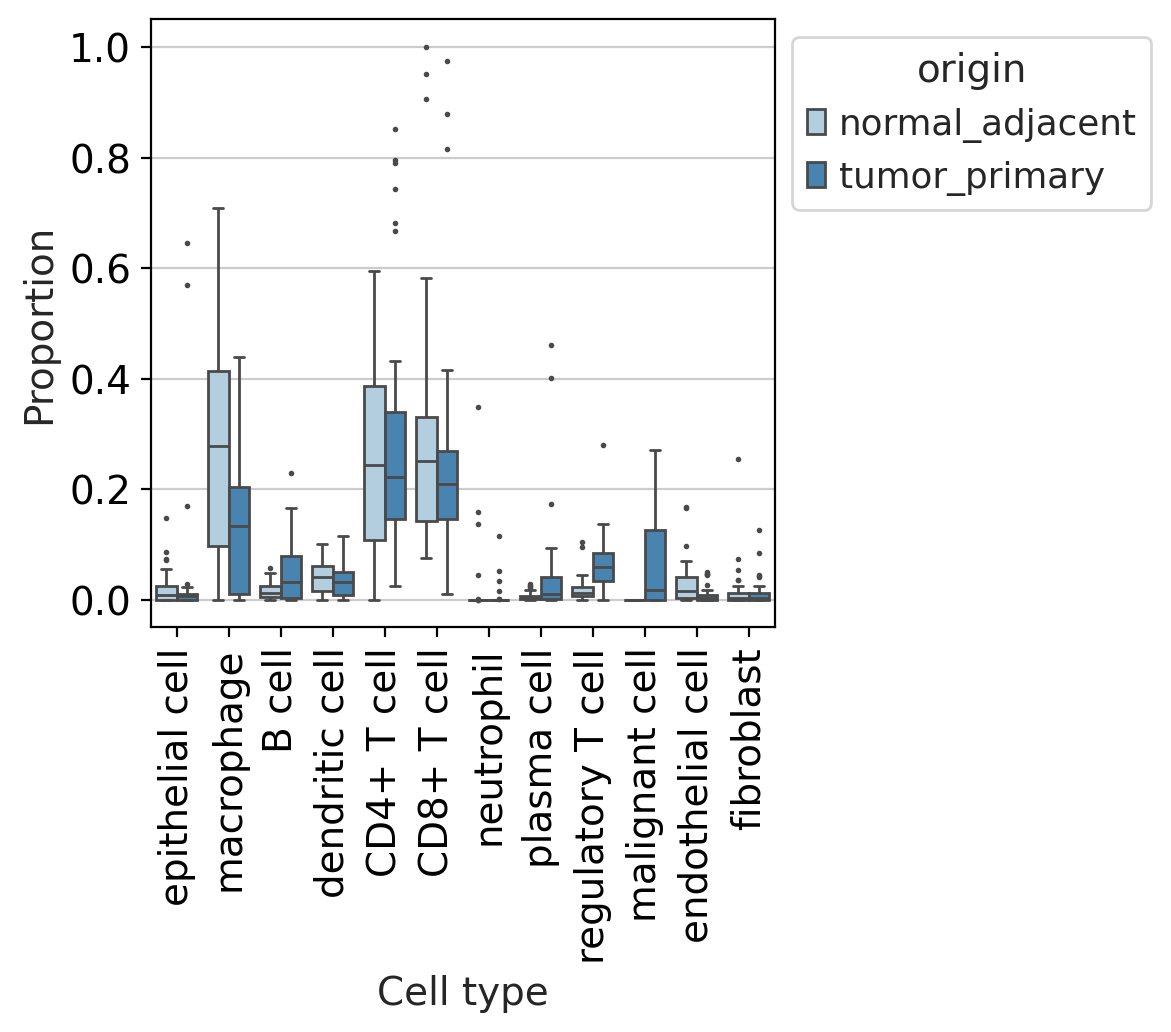

In [64]:
sccoda_model.plot_boxplots(sccoda_data, modality_key="coda_tumor_mvsf", feature_name="origin", add_dots=False)
plt.show()

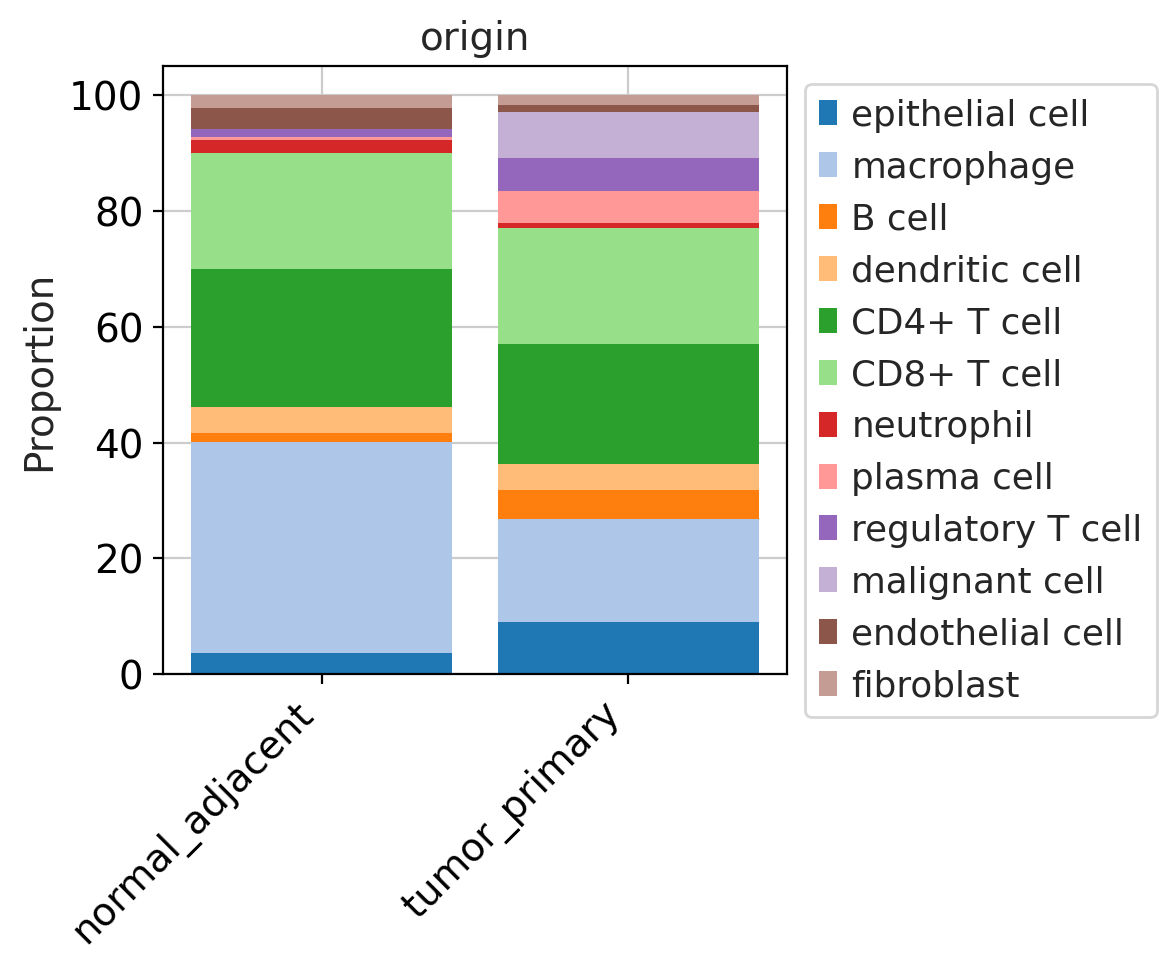

In [32]:
fig = sccoda_model.plot_stacked_barplot(
    sccoda_data,
    modality_key="coda_tumor_mvsf",
    feature_name="origin"

)

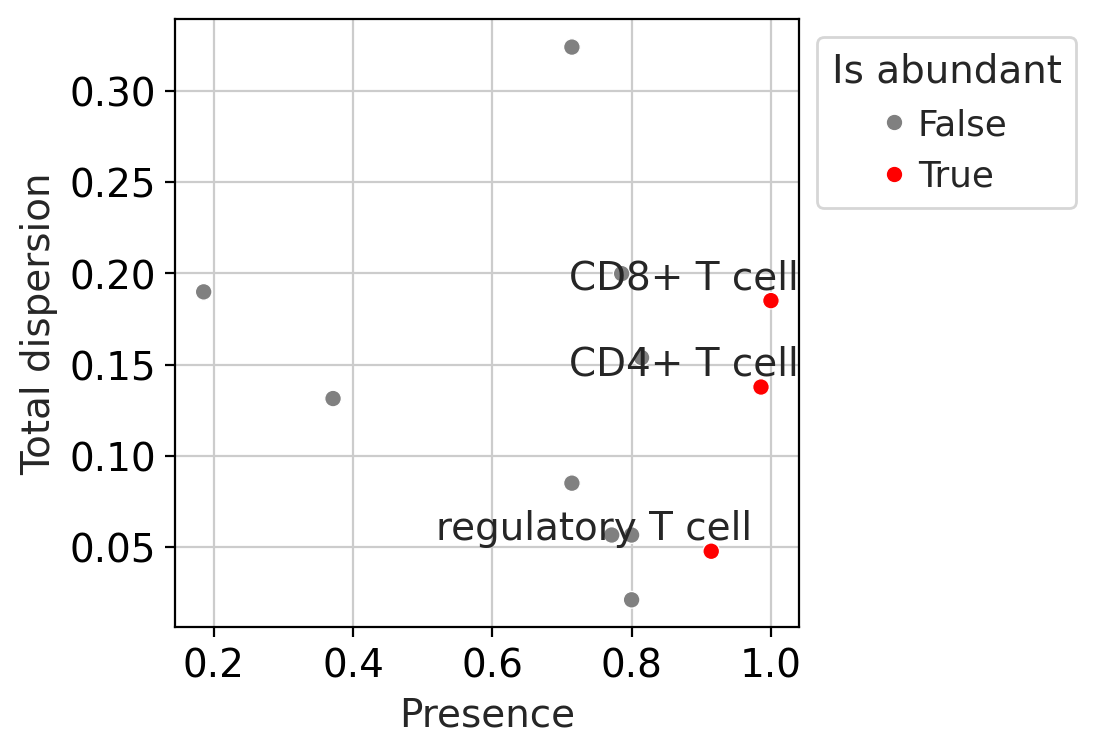

In [33]:
sccoda_model.plot_rel_abundance_dispersion_plot(sccoda_data, modality_key="coda_tumor_mvsf", abundant_threshold=0.9)

In [34]:
sccoda_data = sccoda_model.prepare(
    sccoda_data,
    modality_key="coda_tumor_mvsf",
   formula = "sex + origin",
    reference_cell_type="automatic",
    automatic_reference_absence_threshold=1
)
sccoda_data["coda_tumor_mvsf"]

• Automatic reference selection! Reference cell type set to dendritic cell
• Zero counts encountered in data! Added a pseudocount of 0.5.


AnnData object with n_obs × n_vars = 70 × 12
    obs: 'age', 'dataset', 'origin', 'sex', 'sample', 'disease'
    var: 'n_cells'
    uns: 'scCODA_params'
    obsm: 'covariate_matrix', 'sample_counts'

In [35]:
sccoda_data

MuData object with n_obs × n_vars = 165279 × 17823
  3 modalities
    rna:	165209 x 17811
      obs:	'sample', 'uicc_stage', 'ever_smoker', 'age', 'donor_id', 'origin', 'dataset', 'ann_fine', 'cell_type_predicted', 'doublet_status', 'leiden', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'ann_coarse', 'cell_type_tumor', 'tumor_stage', 'EGFR_mutation', 'TP53_mutation', 'ALK_mutation', 'BRAF_mutation', 'ERBB2_mutation', 'KRAS_mutation', 'ROS_mutation', 'origin_fine', 'study', 'platform', 'cell_type_major', 'cell_type_neutro', 'cell_type_neutro_coarse', 'suspension_type', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'standardized_cell_type', 'scCODA_sample_id'
      var:	'is_highly_variable', 'mito', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype'
      uns:	'_scvi', 'ann_fine_colors', 'batch_condition', 'cell_type_major_colors', 'cell_type_tumor_colors', 'dataset_colors', 'default_embedding', 'hvg', 'log1p', 'neighbors', 'origin_colors', 'platform_colors', 'schema_version', 'sex_colors', 'title', 'umap'
      obsm:	'X_scANVI', 'X_scVI', 'X_umap'
      layers:	'count', 'counts_length_scaled', 'log1p_norm'
      obsp:	'connectivities', 'distances'
    coda:	70 x 12
      obs:	'age', 'dataset', 'origin', 'sex', 'sample', 'disease'
      var:	'n_cells'
    coda_tumor_mvsf:	70 x 12
      obs:	'age', 'dataset', 'origin', 'sex', 'sample', 'disease'
      var:	'n_cells'
      uns:	'scCODA_params'
      obsm:	'covariate_matrix', 'sample_counts'

In [36]:
# Run MCMC
sccoda_model.run_nuts(sccoda_data, modality_key="coda_tumor_mvsf")
sccoda_data["coda_tumor_mvsf"]

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
sample: 100%|██████████| 11000/11000 [07:15<00:00, 25.26it/s, 255 steps of size 1.94e-02. acc. prob=0.83]


AnnData object with n_obs × n_vars = 70 × 12
    obs: 'age', 'dataset', 'origin', 'sex', 'sample', 'disease'
    var: 'n_cells'
    uns: 'scCODA_params'
    obsm: 'covariate_matrix', 'sample_counts'
    varm: 'intercept_df', 'effect_df_origin[T.tumor_primary]'

In [37]:
sccoda_model.set_fdr(sccoda_data, modality_key="coda_tumor_mvsf", est_fdr=0.2)

In [38]:
sccoda_model.summary(sccoda_data, modality_key="coda_tumor_mvsf")

                                          Compositional Analysis summary                                           
┌────────────────────────────────────────────┬────────────────────────────────────────────────────────────────────┐
│ Name                                       │ Value                                                              │
├────────────────────────────────────────────┼────────────────────────────────────────────────────────────────────┤
│ Data                                       │ Data: 70 samples, 12 cell types                                    │
│ Reference cell type                        │ dendritic cell                                                     │
│ Formula                                    │ sex + origin                                                       │
└────────────────────────────────────────────┴────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Intercepts                                                                                                      │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                    Final Parameter  Expected Sample                                                             │
│ Cell Type                                                                                                       │
│ epithelial cell        -0.936           80.612                                                                  │
│ macrophage              0.787          451.535                                                                  │
│ B cell                 -0.668          105.388                                                                  │
│ dendritic cell         -0.402          137.504                                                                  │
│ CD4+ T cell             1.021          570.579                                                                  │
│ CD8+ T cell             1.056          590.903                                                                  │
│ neutrophil             -1.599           41.540                                                                  │
│ plasma cell            -1.048           72.071                                                                  │
│ regulatory T cell      -0.625          110.019                                                                  │
│ malignant cell         -1.690           37.927                                                                  │
│ endothelial cell       -0.788           93.471                                                                  │
│ fibroblast             -1.075           70.151                                                                  │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects                                                                                                         │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                          Final Parameter  Expected Sample  log2-fold change                     │
│ Covariate             Cell Type                                                                                 │
│ originT.tumor_primary epithelial cell         0.000           83.080             0.043                          │
│                       macrophage             -0.635          246.544            -0.873                          │
│                       B cell                  0.000          108.614             0.043                          │
│                       dendritic cell          0.000          141.712             0.043                          │
│                       CD4+ T cell             0.000          588.043             0.043                          │
│                       CD8+ T cell             0.000          608.989             0.043                          │
│                       neutrophil              0.000           42.811             0.043                          │
│                       plasma cell             0.383          108.896             0.595                          │
│                       regulatory T cell       0.510          188.824             0.779                          │
│                       malignant cell          0.987          104.856             1.467                          │
│                       endothelial cell       -0.363           67.034            -0.480                          │
│                       fibroblast              0.000           72.298             0.043                          │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

In [39]:
sccoda_model.summary(sccoda_data, modality_key="coda_tumor_mvsf", extended=True)

                                          Compositional Analysis summary                                           
┌───────────────────────────────────────┬─────────────────────────────────────────────────────────────────────────┐
│ Name                                  │ Value                                                                   │
├───────────────────────────────────────┼─────────────────────────────────────────────────────────────────────────┤
│ Data                                  │ Data: 70 samples, 12 cell types                                         │
│ Reference cell type                   │ dendritic cell                                                          │
│ Formula                               │ sex + origin                                                            │
│ Reference index                       │ 3                                                                       │
│ Spike-and-slab threshold              │ 0.639                                                                   │
│ Spike-and-slab threshold              │ 0.639                                                                   │
│ MCMC Sampling                         │ Sampled 10000 chain states (1000 burnin samples)                        │
│ Acceptance rate                       │ 82.5%                                                                   │
└───────────────────────────────────────┴─────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Intercepts                                                                                                      │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                    Final Parameter  HDI 3%  HDI 97%   SD   Expected Sample                                      │
│ Cell Type                                                                                                       │
│ epithelial cell        -0.936       -1.193  -0.682  0.135      80.612                                           │
│ macrophage              0.787        0.512   1.058  0.146     451.535                                           │
│ B cell                 -0.668       -0.970  -0.386  0.156     105.388                                           │
│ dendritic cell         -0.402       -0.622  -0.193  0.116     137.504                                           │
│ CD4+ T cell             1.021        0.823   1.202  0.102     570.579                                           │
│ CD8+ T cell             1.056        0.831   1.304  0.129     590.903                                           │
│ neutrophil             -1.599       -1.864  -1.336  0.141      41.540                                           │
│ plasma cell            -1.048       -1.380  -0.729  0.178      72.071                                           │
│ regulatory T cell      -0.625       -0.939  -0.288  0.177     110.019                                           │
│ malignant cell         -1.690       -2.022  -1.361  0.178      37.927                                           │
│ endothelial cell       -0.788       -1.115  -0.442  0.184      93.471                                           │
│ fibroblast             -1.075       -1.326  -0.813  0.135      70.151                                           │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects                                                                                                         │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                          Final Parameter  Expected Sample  log2-fold change                     │
│ Covariate             Cell Type                                                                                 │
│ originT.tumor_primary epithelial cell         0.000           83.080             0.043                          │
│                       macrophage             -0.635          246.544            -0.873                          │
│                       B cell                  0.000          108.614             0.043                          │
│                       dendritic cell          0.000          141.712             0.043                          │
│                       CD4+ T cell             0.000          588.043             0.043                          │
│                       CD8+ T cell             0.000          608.989             0.043                          │
│                       neutrophil              0.000           42.811             0.043                          │
│                       plasma cell             0.383          108.896             0.595                          │
│                       regulatory T cell       0.510          188.824             0.779                          │
│                       malignant cell          0.987          104.856             1.467                          │
│                       endothelial cell       -0.363           67.034            -0.480                          │
│                       fibroblast              0.000           72.298             0.043                          │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects Extended                                                                                                │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                          HDI 3%  HDI 97%   SD   Inclusion probability                           │
│ Covariate             Cell Type                                                                                 │
│ originT.tumor_primary epithelial cell    -0.503   0.261  0.124         0.331                                    │
│                       macrophage         -1.002  -0.255  0.199         0.994                                    │
│                       B cell             -0.101   0.665  0.203         0.496                                    │
│                       dendritic cell      0.000   0.000  0.000         0.000                                    │
│                       CD4+ T cell        -0.286   0.287  0.082         0.285                                    │
│                       CD8+ T cell        -0.526   0.040  0.170         0.560                                    │
│                       neutrophil         -0.429   0.362  0.121         0.327                                    │
│                       plasma cell        -0.021   0.801  0.259         0.682                                    │
│                       regulatory T cell   0.068   0.915  0.260         0.889                                    │
│                       malignant cell      0.517   1.432  0.243         1.000                                    │
│                       endothelial cell   -0.779   0.026  0.253         0.639                                    │
│                       fibroblast         -0.442   0.324  0.119         0.346                                    │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

In [40]:
sccoda_model.credible_effects(sccoda_data, modality_key="coda_tumor_mvsf")

Covariate                Cell Type        
origin[T.tumor_primary]  epithelial cell      False
                         macrophage            True
                         B cell               False
                         dendritic cell       False
                         CD4+ T cell          False
                         CD8+ T cell          False
                         neutrophil           False
                         plasma cell           True
                         regulatory T cell     True
                         malignant cell        True
                         endothelial cell      True
                         fibroblast           False
Name: Final Parameter, dtype: bool

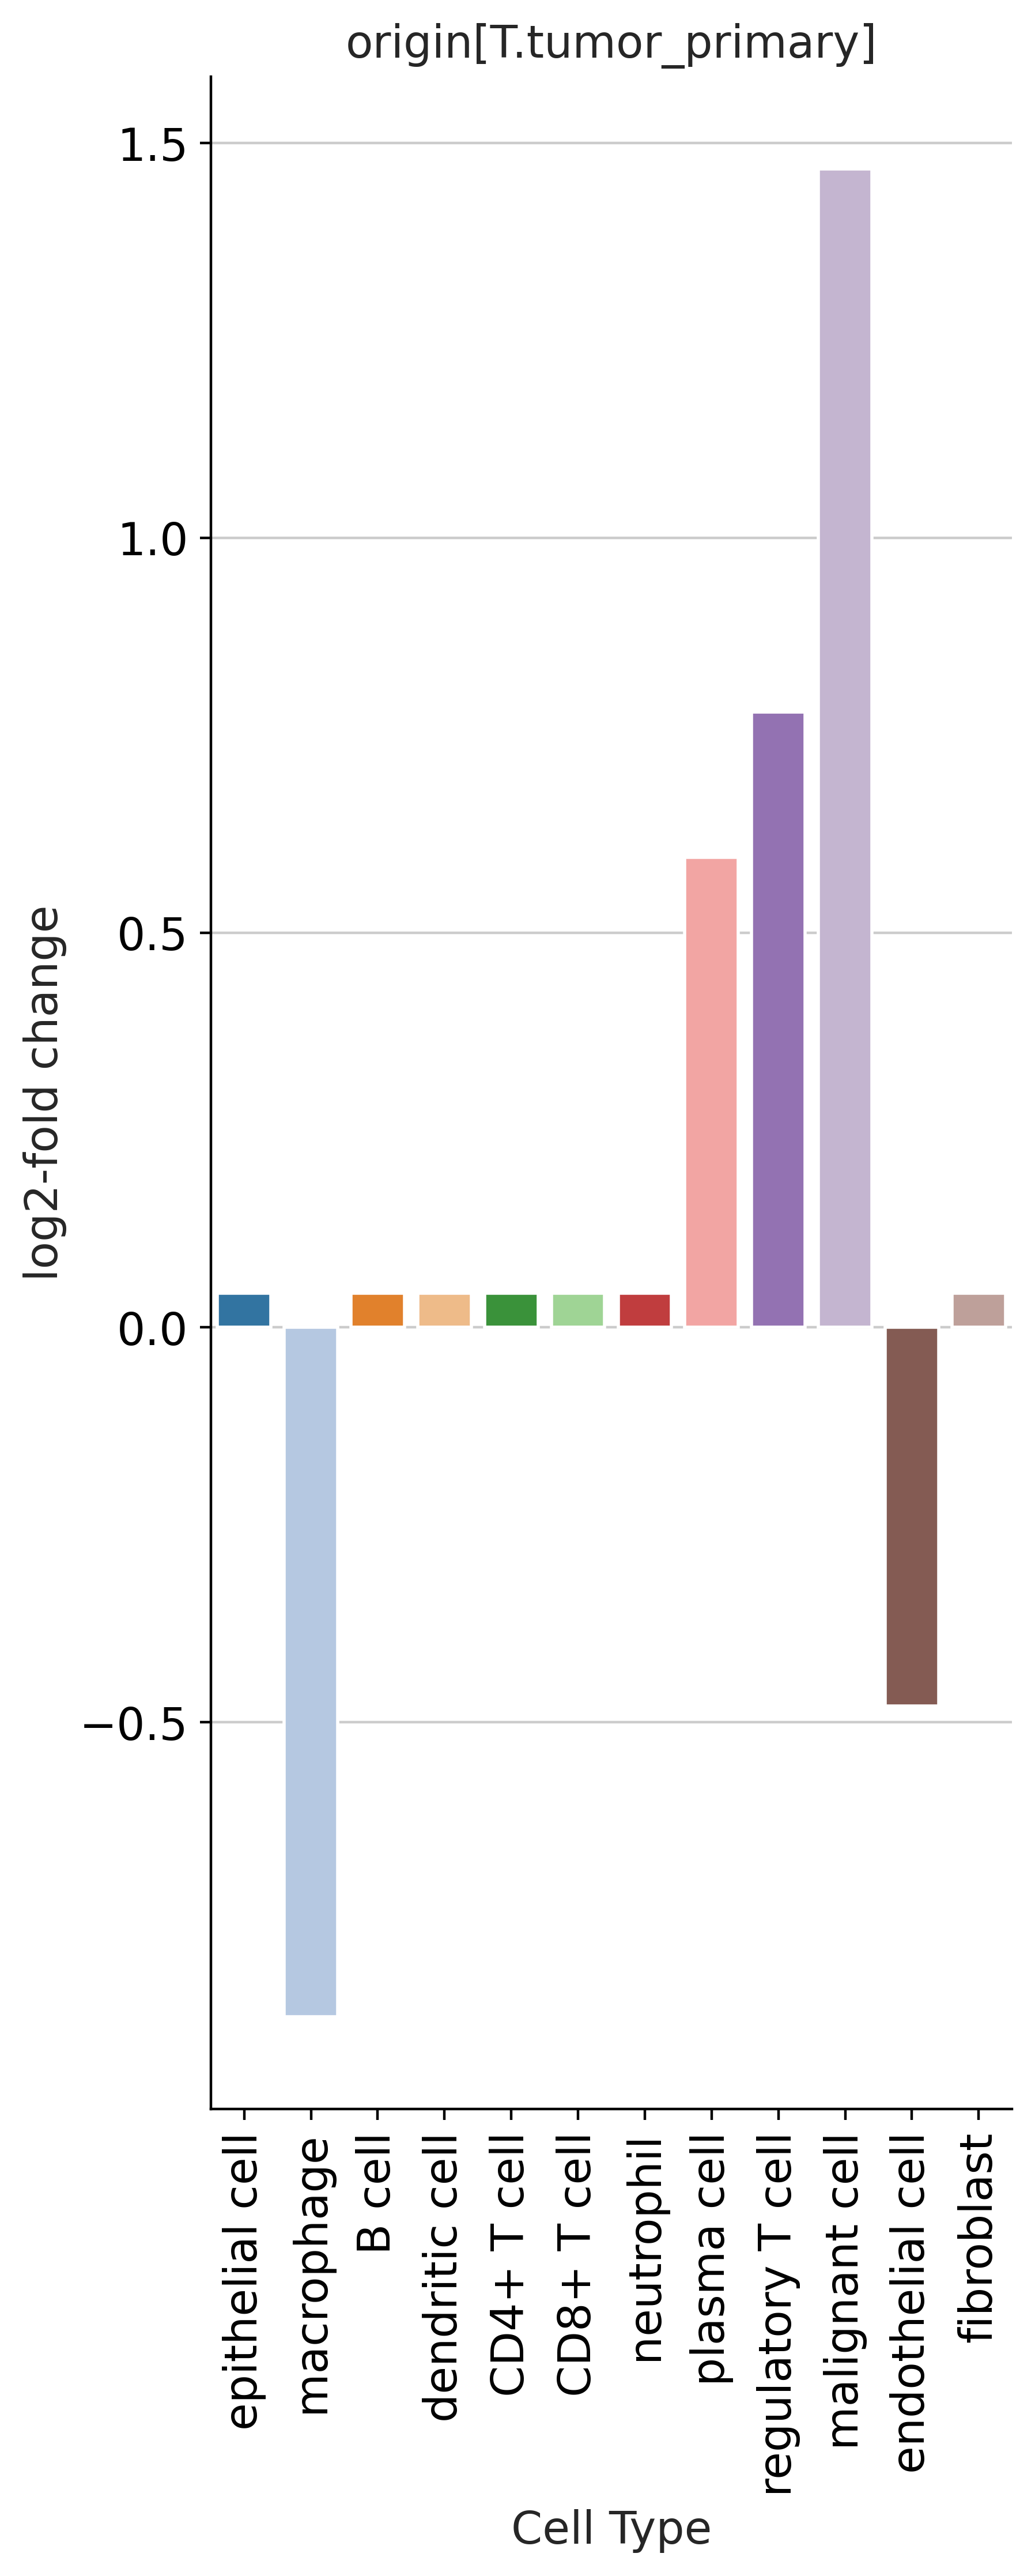

In [41]:
sccoda_model.plot_effects_barplot(sccoda_data, modality_key="coda_tumor_mvsf", parameter="log2-fold change",figsize=(10,5))

In [42]:
sccoda_model.get_effect_df(sccoda_data, modality_key="coda_tumor_mvsf")

Final Parameter  HDI 3%  HDI 97%  \
Covariate             Cell Type                                             
originT.tumor_primary epithelial cell           0.000000  -0.503    0.261   
                      macrophage               -0.635261  -1.002   -0.255   
                      B cell                    0.000000  -0.101    0.665   
                      dendritic cell            0.000000   0.000    0.000   
                      CD4+ T cell               0.000000  -0.286    0.287   
                      CD8+ T cell               0.000000  -0.526    0.040   
                      neutrophil                0.000000  -0.429    0.362   
                      plasma cell               0.382594  -0.021    0.801   
                      regulatory T cell         0.510015   0.068    0.915   
                      malignant cell            0.986787   0.517    1.432   
                      endothelial cell         -0.362606  -0.779    0.026   
                      fibroblast                0.000000  -0.442    0.324   

                                            SD  Inclusion probability  \
Covariate             Cell Type                                         
originT.tumor_primary epithelial cell    0.124                 0.3307   
                      macrophage         0.199                 0.9936   
                      B cell             0.203                 0.4963   
                      dendritic cell     0.000                 0.0000   
                      CD4+ T cell        0.082                 0.2852   
                      CD8+ T cell        0.170                 0.5602   
                      neutrophil         0.121                 0.3267   
                      plasma cell        0.259                 0.6817   
                      regulatory T cell  0.260                 0.8894   
                      malignant cell     0.243                 0.9995   
                      endothelial cell   0.253                 0.6395   
                      fibroblast         0.119                 0.3461   

                                         Expected Sample  log2-fold change  
Covariate             Cell Type                                             
originT.tumor_primary epithelial cell          83.079655          0.043494  
                      macrophage              246.543508         -0.872994  
                      B cell                  108.613949          0.043494  
                      dendritic cell          141.712427          0.043494  
                      CD4+ T cell             588.042864          0.043494  
                      CD8+ T cell             608.988779          0.043494  
                      neutrophil               42.811204          0.043494  
                      plasma cell             108.896038          0.595460  
                      regulatory T cell       188.823835          0.779290  
                      malignant cell          104.855925          1.467127  
                      endothelial cell         67.033572         -0.479636  
                      fibroblast               72.298244          0.043494

In [43]:
alt.Chart(sccoda_model.get_effect_df(sccoda_data, modality_key="coda_tumor_mvsf").loc["originT.tumor_primary"]
    #.loc[credible_effects_condition]
    .reset_index(),
    title="Only Male Tumor vs Normal",
).mark_bar().encode(
    x="log2-fold change",
    y=alt.X("Cell Type", sort="y"),
    color=alt.Color("Cell Type"),
)

alt.Chart(...)

# Only Female Tumor vs Normal 

In [65]:
adata_luad_female = adata_luad[adata_luad.obs["sex"]=="female"]

In [66]:
adata_luad_female.obs.sex.value_counts()

sex
female    235978
Name: count, dtype: int64

In [67]:
# Convert data to mudata object
sccoda_model = pt.tl.Sccoda()
sccoda_data = sccoda_model.load(
    adata_luad_female,
    type="cell_level",
    generate_sample_level=True,
    cell_type_identifier="standardized_cell_type",
    sample_identifier="sample",
    covariate_obs=["age","sex","dataset","origin","disease"],
)

# Select control and salmonella data as one modality
sccoda_data.mod["coda_tumor_mvsf"] = sccoda_data["coda"][
    sccoda_data["coda"].obs["origin"].isin(["tumor_primary", "normal_adjacent"])
].copy()
print(sccoda_data)



MuData object with n_obs × n_vars = 236084 × 17823
  3 modalities
    rna:	235978 x 17811
      obs:	'sample', 'uicc_stage', 'ever_smoker', 'age', 'donor_id', 'origin', 'dataset', 'ann_fine', 'cell_type_predicted', 'doublet_status', 'leiden', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'ann_coarse', 'cell_type_tumor', 'tumor_stage', 'EGFR_mutation', 'TP53_mutation', 'ALK_mutation', 'BRAF_mutation', 'ERBB2_mutation', 'KRAS_mutation', 'ROS_mutation', 'origin_fine', 'study', 'platform', 'cell_type_major', 'cell_type_neutro', 'cell_type_neutro_coarse', 'suspension_type', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'standardized_cell

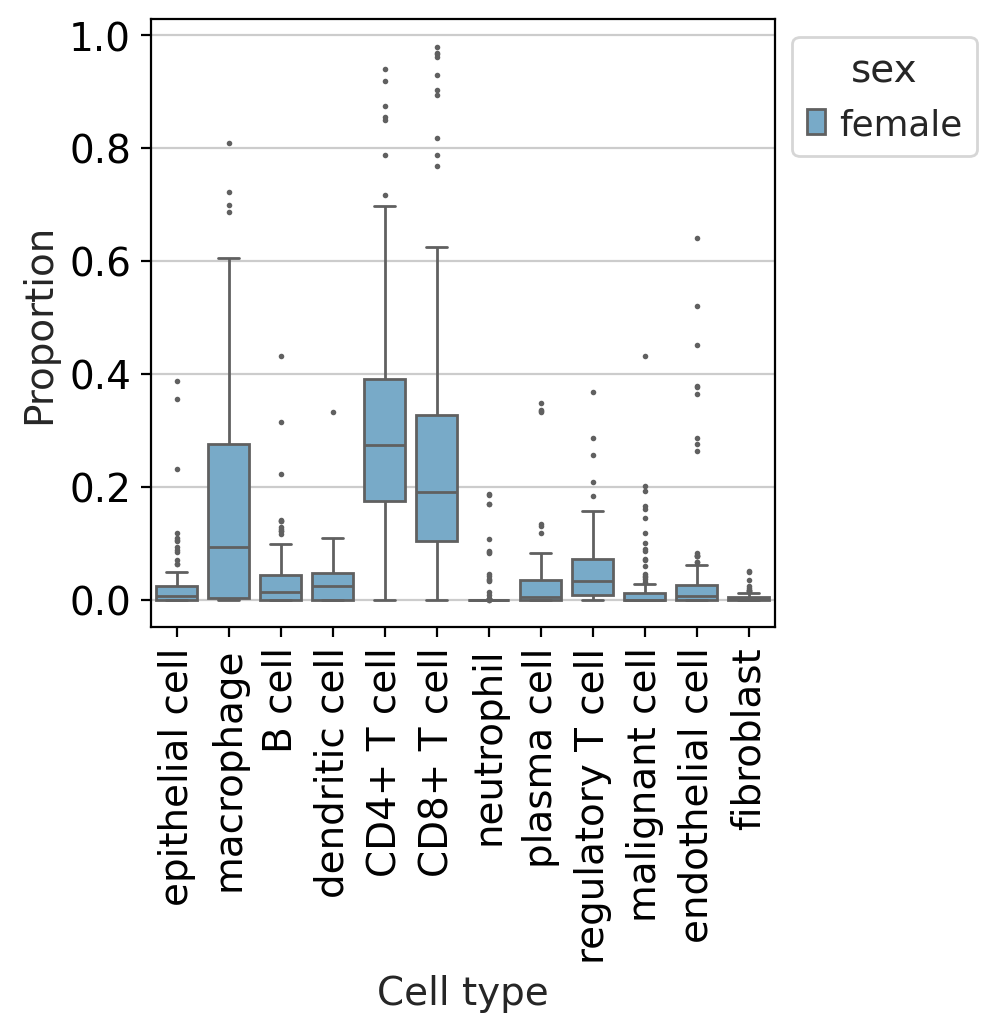

In [68]:
sccoda_model.plot_boxplots(sccoda_data, modality_key="coda_tumor_mvsf", feature_name="sex", add_dots=False)
plt.show()

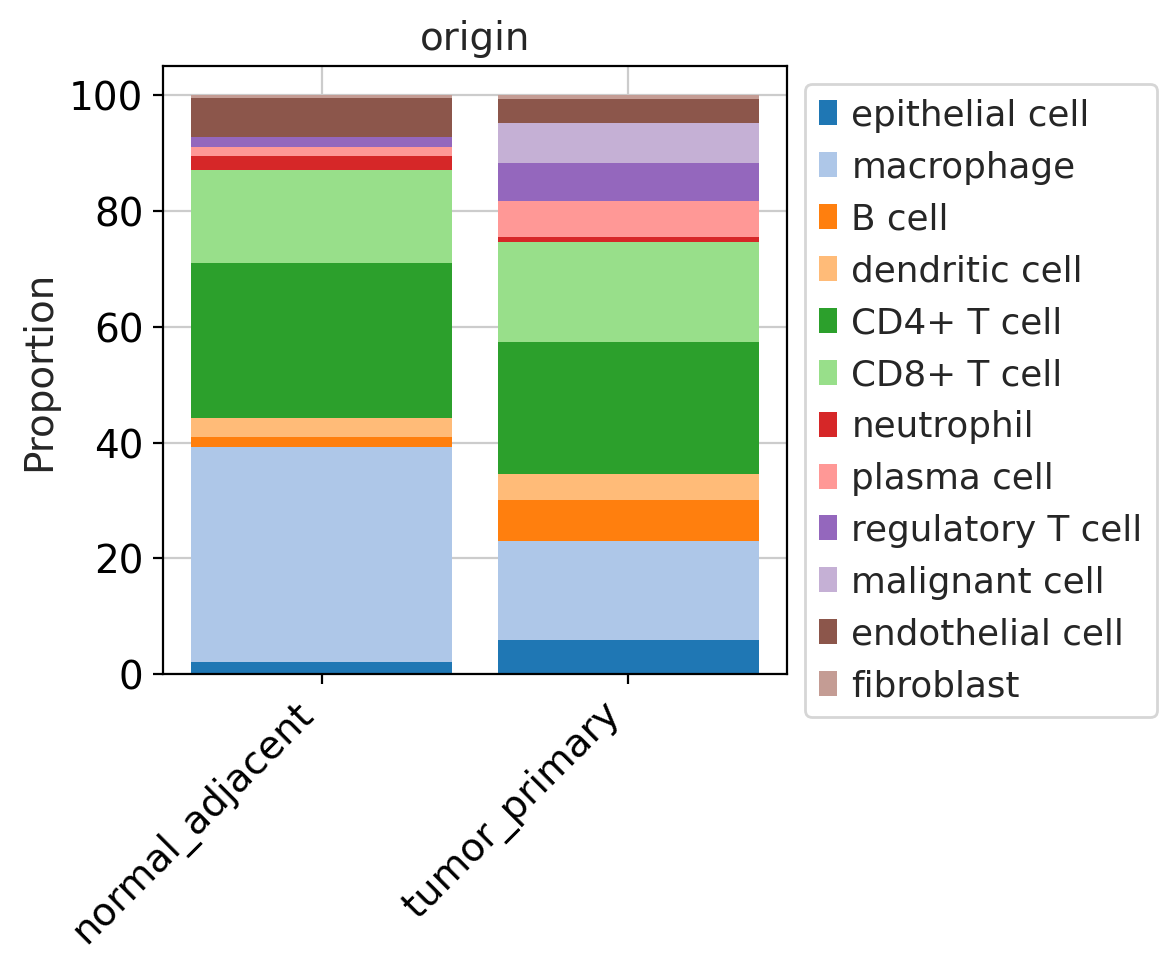

In [48]:
fig = sccoda_model.plot_stacked_barplot(
    sccoda_data,
    modality_key="coda_tumor_mvsf",
    feature_name="origin"

)

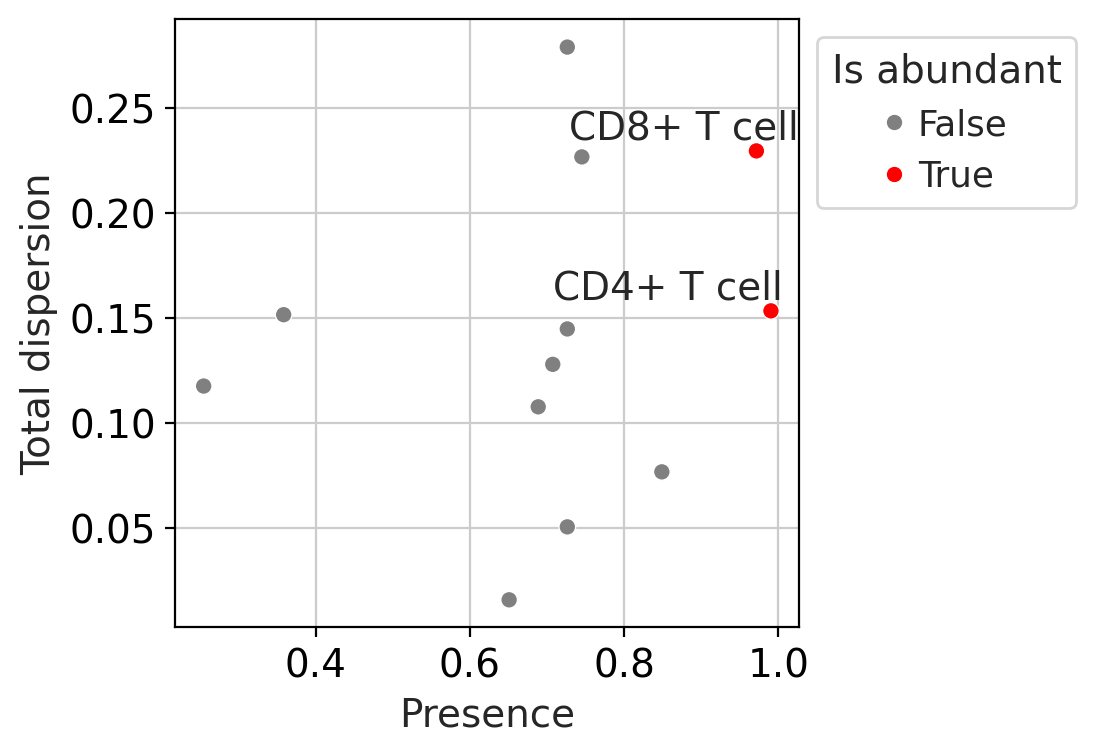

In [49]:
sccoda_model.plot_rel_abundance_dispersion_plot(sccoda_data, modality_key="coda_tumor_mvsf", abundant_threshold=0.9)

In [50]:
sccoda_data = sccoda_model.prepare(
    sccoda_data,
    modality_key="coda_tumor_mvsf",
   formula = "sex + origin",
    reference_cell_type="automatic",
    automatic_reference_absence_threshold=1
)
sccoda_data["coda_tumor_mvsf"]

• Automatic reference selection! Reference cell type set to fibroblast
• Zero counts encountered in data! Added a pseudocount of 0.5.


AnnData object with n_obs × n_vars = 106 × 12
    obs: 'age', 'dataset', 'origin', 'sex', 'sample', 'disease'
    var: 'n_cells'
    uns: 'scCODA_params'
    obsm: 'covariate_matrix', 'sample_counts'

In [51]:
sccoda_data

MuData object with n_obs × n_vars = 236084 × 17823
  3 modalities
    rna:	235978 x 17811
      obs:	'sample', 'uicc_stage', 'ever_smoker', 'age', 'donor_id', 'origin', 'dataset', 'ann_fine', 'cell_type_predicted', 'doublet_status', 'leiden', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'ann_coarse', 'cell_type_tumor', 'tumor_stage', 'EGFR_mutation', 'TP53_mutation', 'ALK_mutation', 'BRAF_mutation', 'ERBB2_mutation', 'KRAS_mutation', 'ROS_mutation', 'origin_fine', 'study', 'platform', 'cell_type_major', 'cell_type_neutro', 'cell_type_neutro_coarse', 'suspension_type', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'standardized_cell_type', 'scCODA_sample_id'
      var:	'is_highly_variable', 'mito', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype'
      uns:	'_scvi', 'ann_fine_colors', 'batch_condition', 'cell_type_major_colors', 'cell_type_tumor_colors', 'dataset_colors', 'default_embedding', 'hvg', 'log1p', 'neighbors', 'origin_colors', 'platform_colors', 'schema_version', 'sex_colors', 'title', 'umap'
      obsm:	'X_scANVI', 'X_scVI', 'X_umap'
      layers:	'count', 'counts_length_scaled', 'log1p_norm'
      obsp:	'connectivities', 'distances'
    coda:	106 x 12
      obs:	'age', 'dataset', 'origin', 'sex', 'sample', 'disease'
      var:	'n_cells'
    coda_tumor_mvsf:	106 x 12
      obs:	'age', 'dataset', 'origin', 'sex', 'sample', 'disease'
      var:	'n_cells'
      uns:	'scCODA_params'
      obsm:	'covariate_matrix', 'sample_counts'

In [52]:
# Run MCMC
sccoda_model.run_nuts(sccoda_data, modality_key="coda_tumor_mvsf")
sccoda_data["coda_tumor_mvsf"]

sample: 100%|██████████| 11000/11000 [10:55<00:00, 16.77it/s, 255 steps of size 1.85e-02. acc. prob=0.85]


AnnData object with n_obs × n_vars = 106 × 12
    obs: 'age', 'dataset', 'origin', 'sex', 'sample', 'disease'
    var: 'n_cells'
    uns: 'scCODA_params'
    obsm: 'covariate_matrix', 'sample_counts'
    varm: 'intercept_df', 'effect_df_origin[T.tumor_primary]'

In [53]:
sccoda_model.set_fdr(sccoda_data, modality_key="coda_tumor_mvsf", est_fdr=0.2)

In [54]:
sccoda_model.summary(sccoda_data, modality_key="coda_tumor_mvsf")

                                          Compositional Analysis summary                                           
┌───────────────────────────────────────────┬─────────────────────────────────────────────────────────────────────┐
│ Name                                      │ Value                                                               │
├───────────────────────────────────────────┼─────────────────────────────────────────────────────────────────────┤
│ Data                                      │ Data: 106 samples, 12 cell types                                    │
│ Reference cell type                       │ fibroblast                                                          │
│ Formula                                   │ sex + origin                                                        │
└───────────────────────────────────────────┴─────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Intercepts                                                                                                      │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                    Final Parameter  Expected Sample                                                             │
│ Cell Type                                                                                                       │
│ epithelial cell        -0.927          108.692                                                                  │
│ macrophage              0.152          319.744                                                                  │
│ B cell                 -0.921          109.346                                                                  │
│ dendritic cell         -0.680          139.145                                                                  │
│ CD4+ T cell             0.730          569.933                                                                  │
│ CD8+ T cell             0.514          459.216                                                                  │
│ neutrophil             -1.555           58.004                                                                  │
│ plasma cell            -1.050           96.113                                                                  │
│ regulatory T cell      -0.826          120.244                                                                  │
│ malignant cell         -1.702           50.075                                                                  │
│ endothelial cell       -0.813          121.817                                                                  │
│ fibroblast             -1.289           75.680                                                                  │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects                                                                                                         │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                          Final Parameter  Expected Sample  log2-fold change                     │
│ Covariate             Cell Type                                                                                 │
│ originT.tumor_primary epithelial cell         0.000          103.304            -0.073                          │
│                       macrophage             -0.353          213.499            -0.583                          │
│                       B cell                  0.395          154.203             0.496                          │
│                       dendritic cell          0.000          132.248            -0.073                          │
│                       CD4+ T cell             0.000          541.681            -0.073                          │
│                       CD8+ T cell             0.000          436.451            -0.073                          │
│                       neutrophil              0.000           55.129            -0.073                          │
│                       plasma cell             0.353          130.024             0.436                          │
│                       regulatory T cell       0.524          193.055             0.683                          │
│                       malignant cell          0.834          109.537             1.129                          │
│                       endothelial cell       -0.286           86.950            -0.486                          │
│                       fibroblast              0.000           71.929            -0.073                          │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

In [55]:
sccoda_model.summary(sccoda_data, modality_key="coda_tumor_mvsf", extended=True)

                                          Compositional Analysis summary                                           
┌───────────────────────────────────────┬─────────────────────────────────────────────────────────────────────────┐
│ Name                                  │ Value                                                                   │
├───────────────────────────────────────┼─────────────────────────────────────────────────────────────────────────┤
│ Data                                  │ Data: 106 samples, 12 cell types                                        │
│ Reference cell type                   │ fibroblast                                                              │
│ Formula                               │ sex + origin                                                            │
│ Reference index                       │ 11                                                                      │
│ Spike-and-slab threshold              │ 0.606                                                                   │
│ Spike-and-slab threshold              │ 0.606                                                                   │
│ MCMC Sampling                         │ Sampled 10000 chain states (1000 burnin samples)                        │
│ Acceptance rate                       │ 85.1%                                                                   │
└───────────────────────────────────────┴─────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Intercepts                                                                                                      │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                    Final Parameter  HDI 3%  HDI 97%   SD   Expected Sample                                      │
│ Cell Type                                                                                                       │
│ epithelial cell        -0.927       -1.161  -0.726  0.114     108.692                                           │
│ macrophage              0.152       -0.118   0.420  0.148     319.744                                           │
│ B cell                 -0.921       -1.188  -0.642  0.150     109.346                                           │
│ dendritic cell         -0.680       -0.894  -0.481  0.111     139.145                                           │
│ CD4+ T cell             0.730        0.561   0.899  0.090     569.933                                           │
│ CD8+ T cell             0.514        0.343   0.681  0.090     459.216                                           │
│ neutrophil             -1.555       -1.763  -1.341  0.112      58.004                                           │
│ plasma cell            -1.050       -1.322  -0.780  0.148      96.113                                           │
│ regulatory T cell      -0.826       -1.095  -0.572  0.138     120.244                                           │
│ malignant cell         -1.702       -1.973  -1.445  0.141      50.075                                           │
│ endothelial cell       -0.813       -1.084  -0.538  0.147     121.817                                           │
│ fibroblast             -1.289       -1.473  -1.105  0.099      75.680                                           │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects                                                                                                         │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                          Final Parameter  Expected Sample  log2-fold change                     │
│ Covariate             Cell Type                                                                                 │
│ originT.tumor_primary epithelial cell         0.000          103.304            -0.073                          │
│                       macrophage             -0.353          213.499            -0.583                          │
│                       B cell                  0.395          154.203             0.496                          │
│                       dendritic cell          0.000          132.248            -0.073                          │
│                       CD4+ T cell             0.000          541.681            -0.073                          │
│                       CD8+ T cell             0.000          436.451            -0.073                          │
│                       neutrophil              0.000           55.129            -0.073                          │
│                       plasma cell             0.353          130.024             0.436                          │
│                       regulatory T cell       0.524          193.055             0.683                          │
│                       malignant cell          0.834          109.537             1.129                          │
│                       endothelial cell       -0.286           86.950            -0.486                          │
│                       fibroblast              0.000           71.929            -0.073                          │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects Extended                                                                                                │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                          HDI 3%  HDI 97%   SD   Inclusion probability                           │
│ Covariate             Cell Type                                                                                 │
│ originT.tumor_primary epithelial cell    -0.165  0.443   0.114         0.373                                    │
│                       macrophage         -0.642  0.003   0.211         0.800                                    │
│                       B cell             -0.002  0.706   0.228         0.822                                    │
│                       dendritic cell     -0.228  0.386   0.096         0.322                                    │
│                       CD4+ T cell        -0.149  0.347   0.081         0.298                                    │
│                       CD8+ T cell        -0.213  0.297   0.071         0.281                                    │
│                       neutrophil         -0.364  0.289   0.101         0.337                                    │
│                       plasma cell        -0.003  0.680   0.223         0.757                                    │
│                       regulatory T cell   0.179  0.869   0.195         0.972                                    │
│                       malignant cell      0.429  1.178   0.198         1.000                                    │
│                       endothelial cell   -0.630  0.026   0.201         0.606                                    │
│                       fibroblast          0.000  0.000   0.000         0.000                                    │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

In [56]:
sccoda_model.credible_effects(sccoda_data, modality_key="coda_tumor_mvsf")

Covariate                Cell Type        
origin[T.tumor_primary]  epithelial cell      False
                         macrophage            True
                         B cell                True
                         dendritic cell       False
                         CD4+ T cell          False
                         CD8+ T cell          False
                         neutrophil           False
                         plasma cell           True
                         regulatory T cell     True
                         malignant cell        True
                         endothelial cell      True
                         fibroblast           False
Name: Final Parameter, dtype: bool

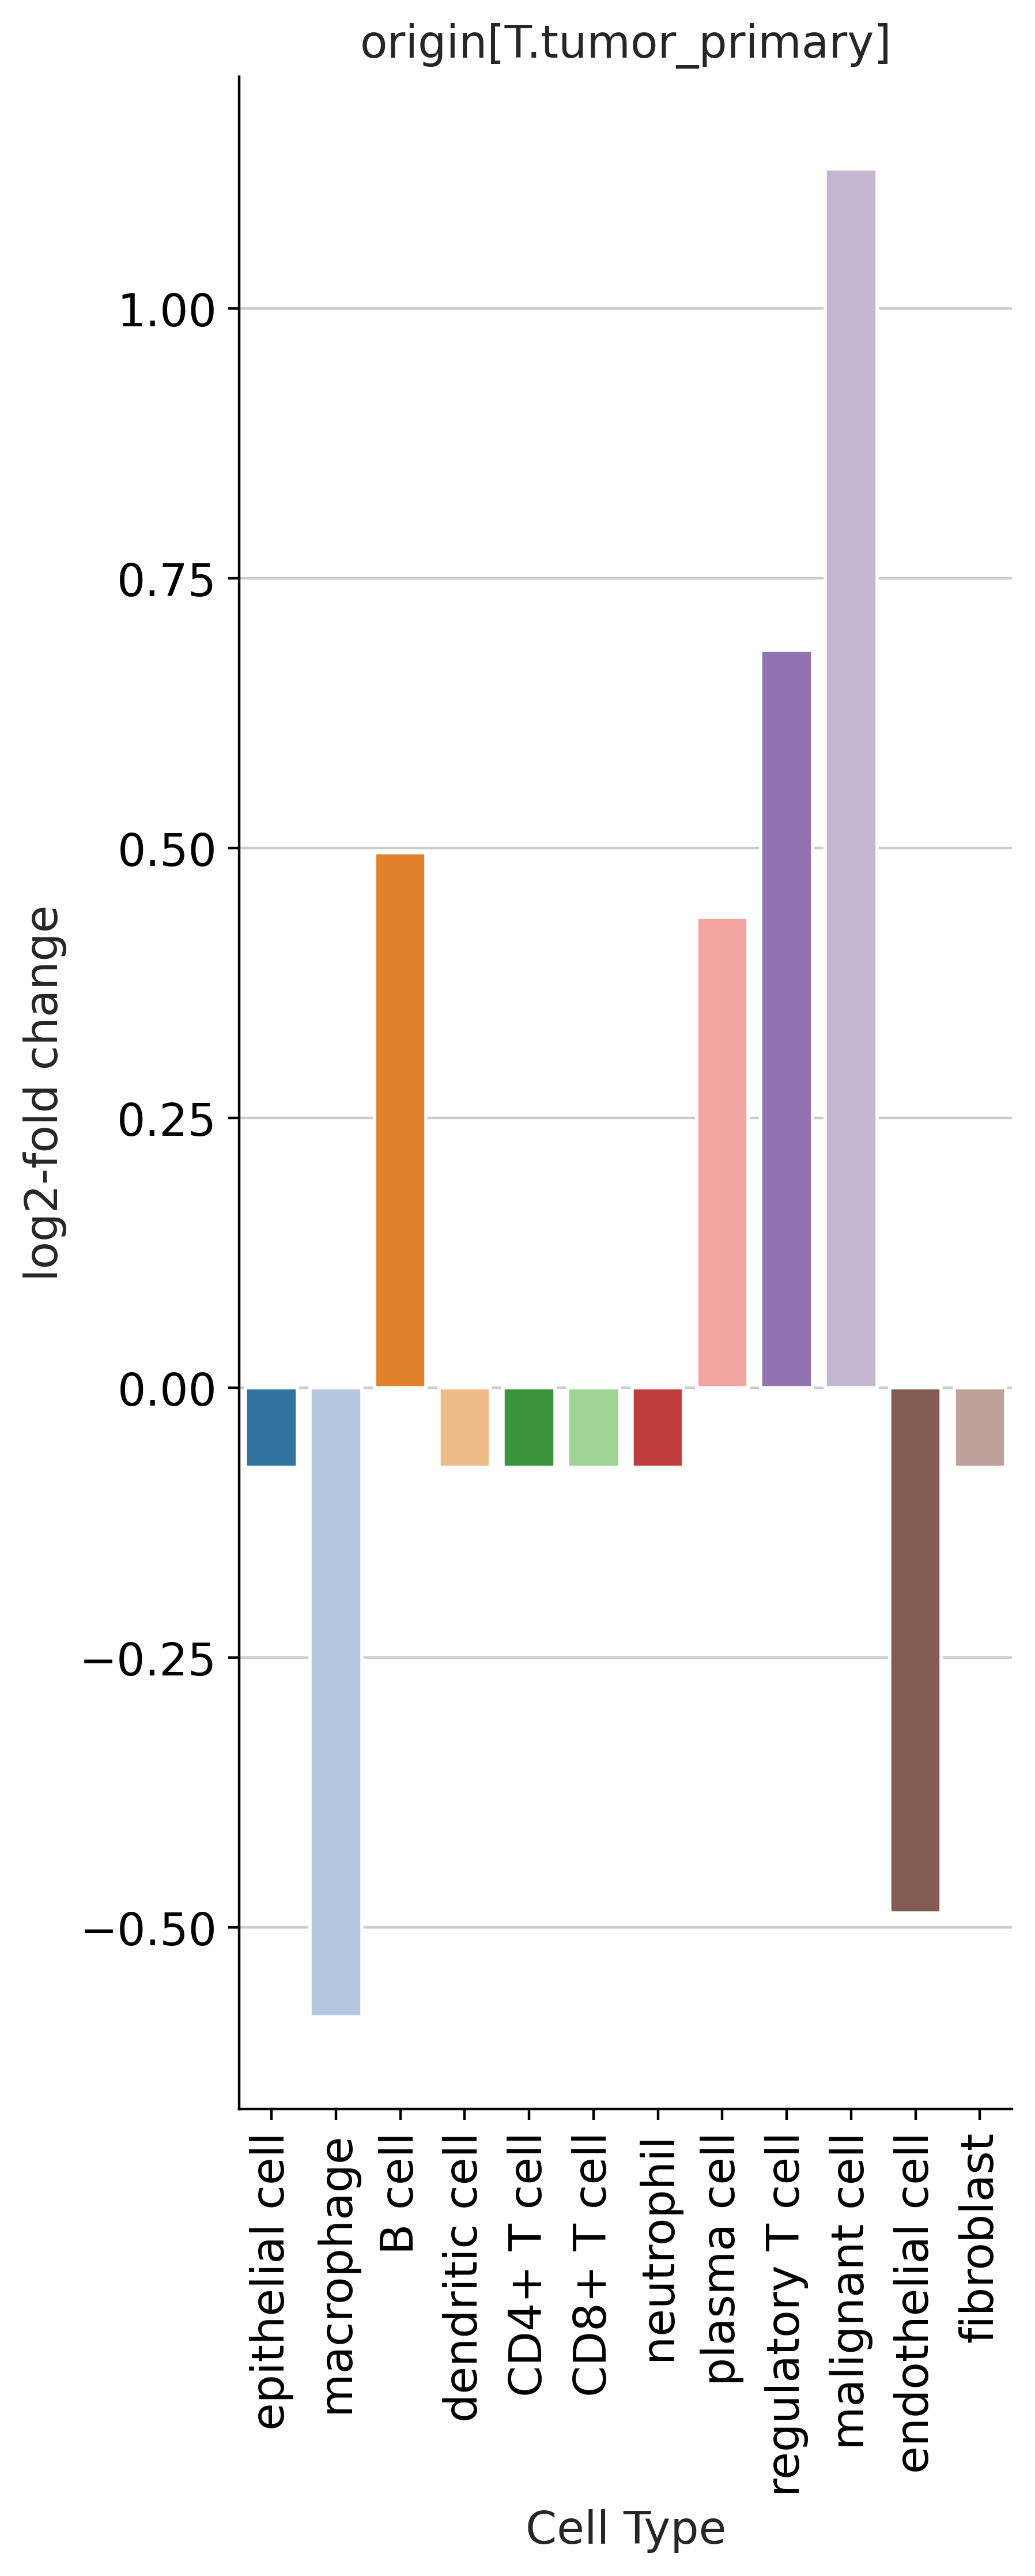

In [57]:
sccoda_model.plot_effects_barplot(sccoda_data, modality_key="coda_tumor_mvsf", parameter="log2-fold change",figsize=(10,5))

In [58]:
sccoda_model.get_effect_df(sccoda_data, modality_key="coda_tumor_mvsf")

Final Parameter  HDI 3%  HDI 97%  \
Covariate             Cell Type                                             
originT.tumor_primary epithelial cell           0.000000  -0.165    0.443   
                      macrophage               -0.353047  -0.642    0.003   
                      B cell                    0.394594  -0.002    0.706   
                      dendritic cell            0.000000  -0.228    0.386   
                      CD4+ T cell               0.000000  -0.149    0.347   
                      CD8+ T cell               0.000000  -0.213    0.297   
                      neutrophil                0.000000  -0.364    0.289   
                      plasma cell               0.353041  -0.003    0.680   
                      regulatory T cell         0.524296   0.179    0.869   
                      malignant cell            0.833587   0.429    1.178   
                      endothelial cell         -0.286343  -0.630    0.026   
                      fibroblast                0.000000   0.000    0.000   

                                            SD  Inclusion probability  \
Covariate             Cell Type                                         
originT.tumor_primary epithelial cell    0.114                 0.3726   
                      macrophage         0.211                 0.7998   
                      B cell             0.228                 0.8220   
                      dendritic cell     0.096                 0.3222   
                      CD4+ T cell        0.081                 0.2979   
                      CD8+ T cell        0.071                 0.2806   
                      neutrophil         0.101                 0.3369   
                      plasma cell        0.223                 0.7570   
                      regulatory T cell  0.195                 0.9717   
                      malignant cell     0.198                 1.0000   
                      endothelial cell   0.201                 0.6063   
                      fibroblast         0.000                 0.0000   

                                         Expected Sample  log2-fold change  
Covariate             Cell Type                                             
originT.tumor_primary epithelial cell         103.304094         -0.073350  
                      macrophage              213.498541         -0.582690  
                      B cell                  154.203156          0.495928  
                      dendritic cell          132.247744         -0.073350  
                      CD4+ T cell             541.680860         -0.073350  
                      CD8+ T cell             436.451391         -0.073350  
                      neutrophil               55.129061         -0.073350  
                      plasma cell             130.023877          0.435980  
                      regulatory T cell       193.054675          0.683049  
                      malignant cell          109.537174          1.129261  
                      endothelial cell         86.950042         -0.486456  
                      fibroblast               71.928819         -0.073350

In [59]:
alt.Chart(sccoda_model.get_effect_df(sccoda_data, modality_key="coda_tumor_mvsf").loc["originT.tumor_primary"]
    #.loc[credible_effects_condition]
    .reset_index(),
    title="Only Female Tumor vs Normal",
).mark_bar().encode(
    x="log2-fold change",
    y=alt.X("Cell Type", sort="y"),
    color=alt.Color("Cell Type"),
)

alt.Chart(...)

In [ ]:
sccoda_data

In [ ]:
sccoda_data["rna"].obs.origin.value_counts()

In [ ]:
adata_luad.obs.origin.value_counts()

In [ ]:
sccoda_model.plot_stacked_barplot(sccoda_data, modality_key="coda_tumor_mvsf", feature_name="origin")
plt.show()

# adata full Male & Female Tumor vs Normal 

In [ ]:
adata.obs.origin.value_counts()

In [ ]:
adata.obs.sex.value_counts()

In [ ]:
adata.obs.disease.value_counts()

In [ ]:
# Convert data to mudata object
sccoda_model = pt.tl.Sccoda()
sccoda_data = sccoda_model.load(
    adata,
    type="cell_level",
    generate_sample_level=True,
    cell_type_identifier="cell_type",
    sample_identifier="sample",
    covariate_obs=["age","sex","dataset","origin","disease"],
)

# Select control and salmonella data as one modality
sccoda_data_all.mod["coda_sex"] = sccoda_data_all["coda"][
    sccoda_data["coda"].obs["sex"].isin(["male", "female"])
].copy()
print(sccoda_data)



In [ ]:
sccoda_model.plot_boxplots(sccoda_data_all, modality_key="coda_sex", feature_name="sex", add_dots=False)
plt.show() #luca

In [ ]:
fig = sccoda_model.plot_stacked_barplot(
    sccoda_data,
    modality_key="coda_sex",
    feature_name="sex"

)

In [ ]:
sccoda_model.plot_rel_abundance_dispersion_plot(sccoda_data, modality_key="coda_sex", abundant_threshold=0.9)

In [ ]:
sccoda_data = sccoda_model.prepare(
    sccoda_data,
    modality_key="coda_sex",
    formula = "sex + origin + disease",
    reference_cell_type="automatic",
    automatic_reference_absence_threshold=1
)
sccoda_data["coda_sex"]

In [ ]:
sccoda_data

In [ ]:
# Run MCMC
sccoda_model.run_nuts(sccoda_data, modality_key="coda_sex")
sccoda_data["coda_sex"]

In [ ]:
sccoda_model.set_fdr(sccoda_data, modality_key="coda_sex", est_fdr=0.2)


In [ ]:
sccoda_model.summary(sccoda_data, modality_key="coda_sex")

In [ ]:
sccoda_model.summary(sccoda_data, modality_key="coda_sex", extended=True)

In [ ]:
sccoda_model.credible_effects(sccoda_data, modality_key="coda_sex")

In [ ]:
sccoda_model.plot_effects_barplot(sccoda_data, modality_key="coda_sex", parameter="log2-fold change",figsize=(10,5))

In [ ]:
sccoda_model.get_effect_df(sccoda_data, modality_key="coda_sex")

In [ ]:
alt.Chart(sccoda_model.get_effect_df(sccoda_data, modality_key="coda_sex").loc["sexT.male"]
    #.loc[credible_effects_condition]
    .reset_index(),
    title="Male vs Female",
).mark_bar().encode(
    x="log2-fold change",
    y=alt.X("Cell Type", sort="y"),
    color=alt.Color("Cell Type"),
)

In [ ]:
alt.Chart(sccoda_model.get_effect_df(sccoda_data, modality_key="coda_sex").loc["originT.tumor_primary"]
    #.loc[credible_effects_condition]
    .reset_index(),
    title="Tumor vs Normal",
).mark_bar().encode(
    x="log2-fold change",
    y=alt.X("Cell Type", sort="y"),
    color=alt.Color("Cell Type"),
)

In [ ]:
sccoda_model.plot_stacked_barplot(sccoda_data, modality_key="coda_sex", feature_name="sex")
plt.show()

In [ ]:
sccoda_model.plot_boxplots(sccoda_data, modality_key="coda_sex", feature_name="sex", add_dots=False)
plt.show()

In [ ]:
adata_male = adata[adata.obs["sex"]=="male"]

In [ ]:
# Convert data to mudata object
sccoda_model = pt.tl.Sccoda()
sccoda_data = sccoda_model.load(
    adata_male,
    type="cell_level",
    generate_sample_level=True,
    cell_type_identifier="cell_type",
    sample_identifier="sample",
    covariate_obs=["age","sex","dataset","origin"],
)

# Select control and salmonella data as one modality
sccoda_data.mod["coda_male_origin"] = sccoda_data["coda"][
    sccoda_data["coda"].obs["origin"].isin(["tumor_primary", "normal_adjacent"])
].copy()
print(sccoda_data)



In [ ]:
sccoda_model.plot_boxplots(sccoda_data, modality_key="coda_male_origin", feature_name="origin", add_dots=False)
plt.show()

In [ ]:
fig = sccoda_model.plot_stacked_barplot(
    sccoda_data,
    modality_key="coda_male_origin",
    feature_name="origin"

)

In [ ]:
sccoda_model.plot_rel_abundance_dispersion_plot(sccoda_data, modality_key="coda_male_origin", abundant_threshold=0.9)

In [ ]:
sccoda_data = sccoda_model.prepare(
    sccoda_data,
    modality_key="coda_male_origin",
    formula = "origin",
    reference_cell_type="automatic",
    automatic_reference_absence_threshold=1
)
sccoda_data["coda_male_origin"]

In [ ]:
sccoda_data

In [ ]:
# Run MCMC
sccoda_model.run_nuts(sccoda_data, modality_key="coda_male_origin")
sccoda_data["coda_male_origin"]

In [ ]:
sccoda_model.set_fdr(sccoda_data, modality_key="coda_male_origin", est_fdr=0.1)


In [ ]:
sccoda_model.summary(sccoda_data, modality_key="coda_male_origin")

In [ ]:
sccoda_model.summary(sccoda_data, modality_key="coda_male_origin", extended=True)

In [ ]:
sccoda_model.credible_effects(sccoda_data, modality_key="coda_male_origin")

In [ ]:
sccoda_model.plot_effects_barplot(sccoda_data, modality_key="coda_male_origin", parameter="log2-fold change",figsize=(10,5))

In [ ]:
sccoda_model.get_effect_df(sccoda_data, modality_key="coda_male_origin")

In [ ]:
alt.Chart(sccoda_model.get_effect_df(sccoda_data, modality_key="coda_male_origin").loc["originT.tumor_primary"]
    #.loc[credible_effects_condition]
    .reset_index(),
    title="Only Male Tumor vs Normal",
).mark_bar().encode(
    x="log2-fold change",
    y=alt.X("Cell Type", sort="y"),
    color=alt.Color("Cell Type"),
)

In [ ]:
sccoda_model.plot_stacked_barplot(sccoda_data, modality_key="coda_male_origin", feature_name="origin")
plt.show()